# Практическая работа 2 «Перенос обучения с использованием MXNet или PyTorch»

## Требования
1. Загрузка данных. Загрузка реализована при выполнении предыдущей работы, поэтому отдельно не оценивается.
2. Построение архитектуры сверточной сети. Построение архитектуры сверточной сети (загрузка и модификация последних слоев). Требуется вывести информацию об архитектуре, опционально выполнить визуализацию сети.
3. Обучение и тестирование модели. Необходимо вывести информацию о способе инициализации весов сети и параметрах алгоритма обучения. Необходимо обеспечить вывод точности классификации на тестовой выборке.
4. Представление результатов. Этап с обучением и тестированием следует выполнить для 4 моделей и с 2 разными конфигурациями (гиперпараметрами/модификациями слоев). Для множества выбранных моделей, обученных для решения исходной задачи необходимо построить сравнительную столбчатую диаграмму точностей: по горизонтали — модель и тип эксперимента (кратко указать параметры), по вертикали — точность. Также следует добавить на график эксперимент из первой практической работы.
5. В конце необходимо вывести информацию о модели, для которой получены лучшие результаты решения задачи: название исходной модели, модифицированные слои, тип эксперимента по переносу обучения, параметры обучения (алгоритм оптимизации и его параметры, способ инициализации весов), полученная точность классификации на тестовой выборке.

### Загрузка библиотек

In [1]:
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import os
import time
from matplotlib import pyplot as plot
import torch
import torchvision
import seaborn as sns



### Установка параметров

In [2]:
root_for_dataset = os.getcwd()
learning_rate = 0.001
num_epochs = 2
size_of_set = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
percentage_accuracy = []

### Функции для загрузки данных, обучении модели, тестировании модели

In [3]:
def load_data(transform):
    trainset = torchvision.datasets.CIFAR10(root=root_for_dataset, train=True,
                                        download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=size_of_set,
                                          shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root=root_for_dataset, train=False,
                                       download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=size_of_set,
                                         shuffle=False, num_workers=2)
    return trainloader, testloader

def train_network(model, trainloader, optimizer):
        for epoch in range(num_epochs):
            start_time = time.time()
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % 100 == 99:
                    print('[%d, %5d] loss: %.3f' %
                            (epoch + 1, i + 1, running_loss / 100))
                    running_loss = 0.0
            epoch_time = time.time() - start_time
            print('Epoch %d took %.2f seconds' % (epoch + 1, epoch_time))
        print('Finished training')

def test_network(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))
    return 100 * correct / total
    

### Функции для обучения последних слоёв сети, для полного обучения сети 

In [4]:
def change_last_layer_unfreezing_parameters(model, updated_layer):
  if hasattr(model, 'fc'):
        model.fc = updated_layer
  elif hasattr(model, 'classifier'):
        model.classifier = updated_layer

  optimizer = optim.Adam(model.parameters(), lr = learning_rate)

  return model, optimizer

def change_last_layer_freezing_parameters(model, updated_layer):
  for param in model.parameters():
    param.requires_grad = False
  if hasattr(model, 'fc'):
        model.fc = updated_layer
        optimizer = optim.Adam(model.fc.parameters(), lr = learning_rate)
  elif hasattr(model, 'classifier'):
        model.classifier = updated_layer
        optimizer = optim.Adam(model.classifier.parameters(), lr = learning_rate)

  return model, optimizer
     

## Модель ResNet18

In [5]:
# ResNet18 unfreezing parameters
weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights)
transforms = weights.transforms()
trainloader, testloader = load_data(transforms)
layers = nn.Linear(model.fc.in_features, len(classes))

updated_model, optimizer = change_last_layer_unfreezing_parameters(model, layers)
print(updated_model)
updated_model.to(device)
train_network(updated_model, trainloader, optimizer)
percentage_accuracy.append(test_network(testloader, updated_model))


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [6]:
# ResNet18 freezing parameters
model = torchvision.models.resnet18(weights)
updated_model, optimizer = change_last_layer_freezing_parameters(model, layers)
updated_model.to(device)
train_network(updated_model, trainloader, optimizer)
percentage_accuracy.append(test_network(testloader, updated_model))

[1,   100] loss: 1.380
[1,   200] loss: 0.915
[1,   300] loss: 0.809
Epoch 1 took 122.92 seconds
[2,   100] loss: 0.718
[2,   200] loss: 0.699
[2,   300] loss: 0.706
Epoch 2 took 124.37 seconds
Finished training
Accuracy of the network on the 10000 test images: 76.70 %


## Модель ResNet34

In [7]:
# GoogleNet unfreezing parameters
weights = torchvision.models.ResNet34_Weights.DEFAULT
model = torchvision.models.resnet34(weights)
transforms = weights.transforms()
trainloader, testloader = load_data(transforms)
layers = nn.Linear(model.fc.in_features, len(classes))
updated_model, optimizer = change_last_layer_unfreezing_parameters(model, layers)
updated_model.to(device)
print(updated_model)
train_network(updated_model, trainloader, optimizer)
percentage_accuracy.append(test_network(testloader, updated_model))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [01:02<00:00, 1.40MB/s]


Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [8]:
# GoogleNet freezing parameters
model = torchvision.models.resnet34(weights)
updated_model, optimizer = change_last_layer_freezing_parameters(model, layers)
updated_model.to(device)
train_network(updated_model, trainloader, optimizer)
percentage_accuracy.append(test_network(testloader, updated_model))

[1,   100] loss: 1.255
[1,   200] loss: 0.845
[1,   300] loss: 0.743
Epoch 1 took 124.61 seconds
[2,   100] loss: 0.667
[2,   200] loss: 0.651
[2,   300] loss: 0.649
Epoch 2 took 125.27 seconds
Finished training
Accuracy of the network on the 10000 test images: 77.91 %


## Модель ShuffleNet_v2_x0_5

In [9]:
# shufflenet_v2_x0_5 unfreezing parameters
weights = torchvision.models.ShuffleNet_V2_X0_5_Weights.DEFAULT
model = torchvision.models.shufflenet_v2_x0_5(weights)
transforms = weights.transforms()
trainloader, testloader = load_data(transforms)
layers = nn.Linear(model.fc.in_features, len(classes))

updated_model, optimizer = change_last_layer_unfreezing_parameters(model, layers)
print(updated_model)
updated_model.to(device)
train_network(updated_model, trainloader, optimizer)
percentage_accuracy.append(test_network(testloader, updated_model))



Files already downloaded and verified
Files already downloaded and verified
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [10]:
# shufflenet_v2_x0_5 freezing parameters
model = torchvision.models.shufflenet_v2_x0_5(weights)
updated_model, optimizer = change_last_layer_freezing_parameters(model, layers)
updated_model.to(device)
train_network(updated_model, trainloader, optimizer)
percentage_accuracy.append(test_network(testloader, updated_model))

[1,   100] loss: 1.946
[1,   200] loss: 1.738
[1,   300] loss: 1.569
Epoch 1 took 124.27 seconds
[2,   100] loss: 1.352
[2,   200] loss: 1.277
[2,   300] loss: 1.208
Epoch 2 took 124.06 seconds
Finished training
Accuracy of the network on the 10000 test images: 70.10 %


## Модель RegNet_y_400mf

In [11]:
# regnet_y_400mf unfreezing parameters
weights = torchvision.models.RegNet_Y_400MF_Weights.DEFAULT
model = torchvision.models.regnet_y_400mf(weights)
transforms = weights.transforms()
trainloader, testloader = load_data(transforms)
layers = nn.Linear(model.fc.in_features, len(classes))

updated_model, optimizer = change_last_layer_unfreezing_parameters(model, layers)
print(updated_model)
updated_model.to(device)
train_network(updated_model, trainloader, optimizer)
percentage_accuracy.append(test_network(testloader, updated_model))

Files already downloaded and verified
Files already downloaded and verified
RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_si

In [12]:
# regnet_y_400mf freezing parameters
model = torchvision.models.regnet_y_400mf(weights)
updated_model, optimizer = change_last_layer_freezing_parameters(model, layers)
updated_model.to(device)
train_network(updated_model, trainloader, optimizer)
percentage_accuracy.append(test_network(testloader, updated_model))

[1,   100] loss: 1.235
[1,   200] loss: 0.933
[1,   300] loss: 0.843
Epoch 1 took 123.72 seconds
[2,   100] loss: 0.772
[2,   200] loss: 0.761
[2,   300] loss: 0.741
Epoch 2 took 122.00 seconds
Finished training
Accuracy of the network on the 10000 test images: 74.79 %


## Гистрограмма точности моделей

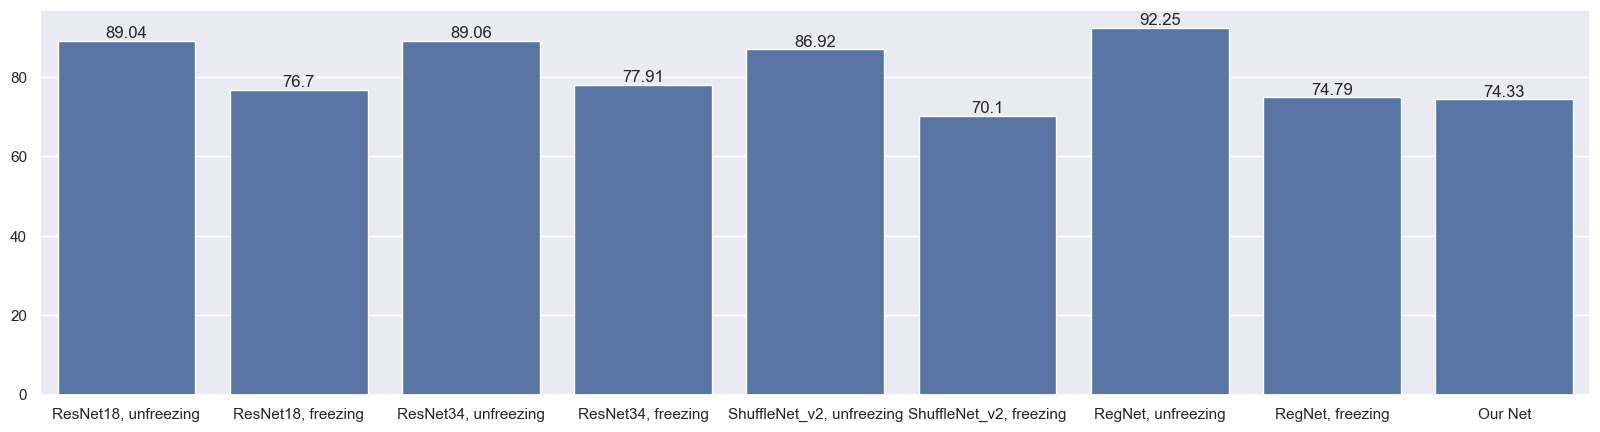

In [13]:
percentage_accuracy.append(74.33)
labels = ["ResNet18, unfreezing", "ResNet18, freezing", "ResNet34, unfreezing", "ResNet34, freezing", "ShuffleNet_v2, unfreezing",
          "ShuffleNet_v2, freezing", "RegNet, unfreezing", "RegNet, freezing", "Our Net"]
sns.set_theme(rc={'figure.figsize': (20, 5)})
ax = sns.barplot(x=labels, y=percentage_accuracy)
for i in ax.containers:
    ax.bar_label(i,)

## Выбор лучшей модели из представленных

In [14]:
best_accuracy = max(percentage_accuracy)
index_max = max(range(len(percentage_accuracy)), key=percentage_accuracy.__getitem__)
best_model = labels[index_max]
print(f'Best accuracy = {best_accuracy} in the model: {best_model}')
print(f'Number of epochs = {num_epochs}, Learning rate = {learning_rate} with batch size = {size_of_set}')

Best accuracy = 92.25 in the model: RegNet, unfreezing
Number of epochs = 2, Learning rate = 0.001 with batch size = 128
